# Semantic chunking

Next, we are going to try using a semantic text splitter to chunk the text to blocks of around 512 tokens.

## 1. Run set-up

We will use semantic-text-splitter from PyPI and the bert base uncased tokenizer from HuggingFace.

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

# Standard ports
import time

# PyPI imports
import h5py
import matplotlib.pyplot as plt
from semantic_text_splitter import TextSplitter
from tokenizers import Tokenizer

# Internal imports
import configuration as config

Working directory: /mnt/arkk/opensearch/semantic_search


In [2]:
input_file=f'{config.DATA_PATH}/wikipedia/{config.BATCHED_TEXT}'

# Total record count determined in data exploration notebook
record_count=13778448

tokenizer_name='bert-base-uncased'
max_tokens=512

tokenizer=Tokenizer.from_pretrained(tokenizer_name)
splitter=TextSplitter.from_huggingface_tokenizer(tokenizer, max_tokens)

## 2. Load data

Load up the first batch from the data extractor.

In [3]:
input_data=h5py.File(input_file, 'r')
batch=input_data['batches/1']

sample_text=' '.join(batch[3].decode('utf-8').split(' ')[:100])

print(f'First batch contains {len(batch)} texts\n')
print(f"Sample text:\n{sample_text}")

First batch contains 48 texts

Sample text:
No toquen a la nena (Don't touch the girl) is a 1976 Argentinian film. It is a comedy of manners directed by Juan José Jusid. The film stars Luis Politti, María Vaner, Norma Aleandro, Lautaro Murúa, Pepe Soriano and Julio de Grazia, among others. Among the roster of extras, the film featured Cecilia Roth in her debut performance, 2 years before she would flee Argentina. When it was released in Argentina, many of its actors had had to go into exile for reasons of political persecution.

The script, written by Oscar Viale and Jorge Goldemberg, received initial approval from the Argentine


## 3. Semantic chunking test
Test split the first text from the first batch:

In [4]:
chunks=splitter.chunks(batch[0].decode('utf-8'))
print(f'Have {len(chunks)} chunks')

for i, chunk in enumerate(chunks[:5]):
    chunk_start=' '.join(chunk.split(' ')[:25])
    chunk_end=' '.join(chunk.split(' ')[-25:])
    print(f'\n{i}: {chunk_start} ... {chunk_end}')

Have 22 chunks

0: Hercule Poirot (, ) is a fictional Belgian detective created by British writer Agatha Christie. Poirot is one of Christie's most famous and long-running characters, ... Hanaud of the French Sûreté, who first appeared in the 1910 novel At the Villa Rose and predates the first Poirot novel by 10 years.

1: Christie's Poirot was clearly the result of her early development of the detective in her first book, written in 1916 and published in 1920. The ... taken to wearing a wig and a false moustache.as Hastings discovers in  However, in many of his screen incarnations, he is bald or balding.

2: Frequent mention is made of his patent leather shoes, damage to which is frequently a source of misery for him, but comical for the reader.E.g. ... the dark throughout the climax. This aspect of Poirot is less evident in the later novels, partly because there is rarely a narrator to mislead.

3: In Murder on the Links, still largely dependent on clues himself, Poirot mocks a rival

OK, pretty good. We didn't break up any sentences. Some chunks start with a pronoun, so they would be a little unclear to read in isolation. But this approach is obviously much better than taking chunks by word count.

It feels snappy too - let's time chunking a few batches and see what we are working with.

## 4. Semantic text chunking rate

In [5]:
%%time

# Number of batches to time chunking for
num_batches=100

# Holder to collect chunking times
chunking_times=[]

for i in range(num_batches):

    # Start the timer
    start_time=time.time()

    # Get the text batch
    batch=input_data[f'batches/{i + 1}']

    # Chunk the records from the batch
    for record in batch:
        chunks=splitter.chunks(record.decode('utf-8'))

    # Stop the timer
    dT=time.time() - start_time
    chunking_times.append(dT/len(batch))

mean_chunking_rate=len(chunking_times)/sum(chunking_times)
print(f'Total chunking time: {((record_count / mean_chunking_rate) / (60**2)):.1f} hours')
print(f'Mean chunking rate {mean_chunking_rate:.1f} records per second\n')

Total chunking time: 67.5 hours
Mean chunking rate 56.7 records per second

CPU times: user 1min 23s, sys: 41.6 ms, total: 1min 23s
Wall time: 1min 23s


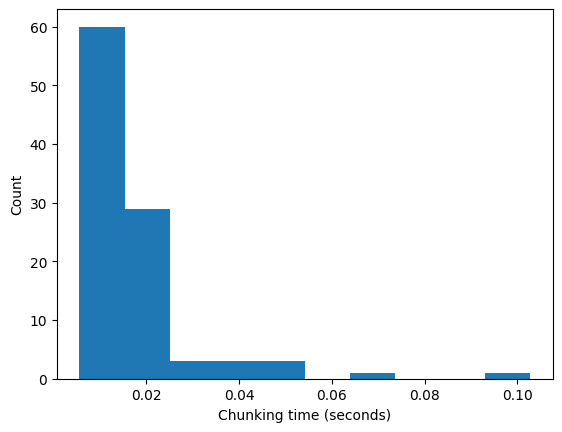

In [6]:
    plt.hist(chunking_times)
    plt.xlabel(f'Chunking time (seconds)')
    plt.ylabel('Count')
    plt.show()

## 5. Results

Single threaded chunking rate is about 70 records per second or approximately 50 hours to chunk all of Wikipedia. Parallelizing that over 18 cores gives us a net run time of just under 4 hours. Combine that with the net two-hour run time of the parser/cleaner functions, and we are looking at a best case scenario of about 6 hrs for the extraction job to complete. All-in-all, not terrible. We can live with overnight, especially considering that the first iteration of this would have taken 8 days to run!